In [1]:
# %matplotlib widget
import numpy as np 
import matplotlib.pyplot as plt 
import jax.numpy as jnp 
from jax import jit, random,vmap
from baseline_mppi_terrain_following import MPPI_base
from pi_mppi_terrain_following import pi_mppi
import time
from jax.scipy.ndimage import map_coordinates


In [2]:
num_case = 1
num = 100 # number of timesteps
num_batch = 1000
nvar = 11

goal_x = 1100 # goal position
goal_y = 1200 # goal position
goal_z = np.random.uniform(10, 20, num_case) # goal position
goal_location = np.vstack((goal_x,goal_y,goal_z)).T

##### Initial state global (Global Frame) ####
x_init_global = -1500
y_init_global = -1500

In [3]:
# Constraints 

v_min = 12.0
v_max = 20.0

vdot_max = 3
vdot_min = -3

vddot_max = 3.0
vddot_min = -3.0

pitch_max = 0.2
pitch_min = -0.2

pitchdot_max = 0.25
pitchdot_min = -0.25

pitchddot_max = 0.15
pitchddot_min = -0.15

roll_max = 0.25
roll_min = -0.25

rolldot_max = 0.25
rolldot_min = -0.25

rollddot_max = 0.15
rollddot_min = -0.15

terrain_upper = 15
terrain_lower = 5

In [4]:
### Terrain Parameters ###
x_range = np.array([-2000, 2000])
y_range = np.array([-2000, 2000])

# Terrain grid size
width = 1800
height = 1800

# Terrain generation parameters
scale = 300.0
octaves = 5
persistence = 0.25
lacunarity = 2.5
altitude_scale = 80
altitude_offset = 1.0

base = 24

### Loading Terrain ###
terrain_data = np.load('./data/terrain2.npz')
x = terrain_data['x']
y = terrain_data['y']
z = terrain_data['z']

In [5]:
### Altitude of terrain at desired starting point ###

def get_terrain_height(x, y, z, width, height, x_range, y_range):

    i = (x - x_range[0]) / (x_range[1] - x_range[0]) * (width - 1)
    j = (y - y_range[0]) / (y_range[1] - y_range[0]) * (height - 1)
    
    height_at_point = map_coordinates(z, [[i], [j]], order=1, mode='nearest')[0]
    
    return height_at_point

x_pos = x_init_global
y_pos = y_init_global

height_at_point = get_terrain_height(x_pos, y_pos, z, width, height, x_range, y_range)

# Initial altitude position
z_init_global = height_at_point + 10


In [6]:
# Initial Conditions/obstacles/goal
# Key generation
key_baseline_init = random.PRNGKey(0)
key_proj_init = random.PRNGKey(0)

# Initial states 
x_init = 0 #ego
y_init = 0 #ego
z_init = 0 #ego
psi_init = jnp.pi/2

# Initial controls
v_init = 16
pitch_init = 0
roll_init = 0

# Initial controls sequence - Baseline MPPI
v_prev = jnp.ones((num))*v_init
pitch_prev = jnp.ones((num))*pitch_init
roll_prev = jnp.ones((num))*roll_init
u_prev = jnp.hstack((v_prev,pitch_prev,roll_prev))

# Mean - Projection MPPI
mean_v_control = jnp.zeros(nvar) 
mean_pitch_control = jnp.zeros(nvar)
mean_roll_control = jnp.zeros(nvar) 

mean_proj_init = jnp.hstack(( mean_v_control, mean_pitch_control, mean_roll_control  ))

# Dot init 
vdot_base_init = 0.
pitchdot_base_init = 0.
rolldot_base_init = 0.

# Dot init - Projection MPPI
vdot_proj_init = 0
pitchdot_proj_init = 0
rolldot_proj_init = 0

In [7]:
# Initialization

mppi_baseline = MPPI_base(num,
                  v_max, v_min, vdot_max, vdot_min, vddot_max,vddot_min,
                    pitch_max,pitch_min, pitchdot_max, pitchdot_min, pitchddot_max, pitchddot_min,
                      roll_max, roll_min, rolldot_max, rolldot_min, rollddot_max, rollddot_min,
                      scale, octaves, persistence, lacunarity, width, height, altitude_scale, altitude_offset,jnp.array(z),x_range,y_range,num_batch)

mppi_proj = pi_mppi(v_max, v_min, vdot_max, vdot_min, vddot_max,vddot_min,
                    pitch_max,pitch_min, pitchdot_max, pitchdot_min, pitchddot_max, pitchddot_min,
                      roll_max, roll_min, rolldot_max, rolldot_min, rollddot_max, rollddot_min,
                      scale, octaves, persistence, lacunarity, width, height, altitude_scale, altitude_offset,jnp.array(z),x_range,y_range,num_batch)

In [8]:
# Number of mpc iterations to be run
timesteps = 2500

# Storing values - Baseline
states_base_global = np.zeros((num_case,timesteps,4))
controls_base = np.zeros((num_case,timesteps,3)) 
dot_base = np.zeros((num_case,timesteps,3))
ddot_base = np.zeros((num_case,timesteps,3))
z_terrain_base = np.zeros((num_case,timesteps))

# Storing Values - Projection
states_proj_global = np.zeros((num_case,timesteps,4))
controls_proj = np.zeros((num_case,timesteps,3))
controls_dot_proj = np.zeros((num_case,timesteps,3)) 
controls_ddot_proj = np.zeros((num_case,timesteps,3))
z_terrain_proj = np.zeros((num_case,timesteps))

states_train = np.zeros((num_case,timesteps,6))
mean_proj_values = np.zeros((num_case,timesteps,33))

# Iterations
iter_left = num_case

In [9]:
for k in range(num_case):


  # Goal Location
  x_goal = goal_location[k,0]    #global 
  y_goal = goal_location[k,1]    #global
  z_goal = goal_location[k,2]    #global

  # Init Base 
  x_init_base_global = x_init_global
  y_init_base_global = y_init_global
  z_init_base_global = z_init_global

  x_goal_base_ego = x_goal
  y_goal_base_ego = y_goal
  z_goal_base_ego = z_goal

  psi_base_init = psi_init
  v_base_init = v_init
  pitch_base_init = pitch_init
  roll_base_init = roll_init

  vdot_base_init = 0
  pitchdot_base_init = 0
  rolldot_base_init = 0

  v_prev = jnp.ones((num))*v_init
  pitch_prev = jnp.ones((num))*pitch_init
  roll_prev = jnp.ones((num))*roll_init
  u_prev = jnp.hstack((v_prev,pitch_prev,roll_prev))
  key_baseline = key_baseline_init


  # Init Proj
  x_init_proj_global = x_init_global
  y_init_proj_global = y_init_global
  z_init_proj_global = z_init_global

  x_goal_proj_ego = x_goal
  y_goal_proj_ego = y_goal
  z_goal_proj_ego = z_goal

  psi_proj_init = psi_init
  v_proj_init = v_init
  pitch_proj_init = pitch_init
  roll_proj_init = roll_init

  vdot_proj_init = 0
  pitchdot_proj_init = 0
  rolldot_proj_init = 0

  mean_proj = mean_proj_init
  start = time.time()
  key_proj = key_proj_init

  
  for i in range(timesteps):
      
    #### Baseline MPPI

    states_jax_baseline = jnp.array([x_init_base_global,y_init_base_global,z_init_base_global,psi_base_init])
    states_base_global[k,i,:] = np.asarray(states_jax_baseline)

    key_baseline, init_states_upd_base, init_controls_upd_base, dot_new_base, ddot_new_base, u_prev = mppi_baseline.mppi_base_main(
                    u_prev, key_baseline,
                    x_init, y_init, z_init, psi_base_init,
                    v_base_init, pitch_base_init, roll_base_init,
                    x_goal_base_ego,y_goal_base_ego,z_goal_base_ego,
                    x_init_base_global,y_init_base_global,z_init_base_global)
    
    # Global location

    x_init_base_global = x_init_base_global + init_states_upd_base[0]
    y_init_base_global = y_init_base_global + init_states_upd_base[1]
    z_init_base_global = z_init_base_global + init_states_upd_base[2]

    # Update
    psi_base_init = init_states_upd_base[3]

    v_base_init, pitch_base_init, roll_base_init = init_controls_upd_base[0],init_controls_upd_base[1],init_controls_upd_base[2]
    controls_jax_base = jnp.array([v_base_init, pitch_base_init, roll_base_init ])
    vdot_base_init, pitchdot_base_init, rolldot_base_init = dot_new_base[0],dot_new_base[1],dot_new_base[2]

    # Storing controls/dot/ddot
    controls_base[k,i,:] = np.asarray(controls_jax_base)
    dot_base[k,i,:] = np.asarray(dot_new_base)
    ddot_base[k,i,:] = np.asarray(ddot_new_base)

    #### Projected MPPI
    states_jax_proj = jnp.array([x_init_proj_global,y_init_proj_global,z_init_proj_global,psi_proj_init])
    states_proj_global[k,i,:] = np.asarray(states_jax_proj)

    mean_proj,key_proj,init_states_upd_proj,init_controls_upd_proj,controls_dot,controls_ddot = mppi_proj.pi_mppi_main(v_proj_init, vdot_proj_init, pitch_proj_init,
                                                                                pitchdot_proj_init, roll_proj_init, rolldot_proj_init,
                                                                                  psi_proj_init,
                                                                                    x_init, y_init, z_init,
                                                                                    x_goal_proj_ego, y_goal_proj_ego, z_goal_proj_ego,
                                                                                      mean_proj,key_proj,
                                                                                      x_init_proj_global,y_init_proj_global,z_init_proj_global
                                                                                      )
                                                                        
    # Global location

    x_init_proj_global = x_init_proj_global + init_states_upd_proj[0]
    y_init_proj_global = y_init_proj_global + init_states_upd_proj[1]
    z_init_proj_global = z_init_proj_global + init_states_upd_proj[2]

    # Update
    psi_proj_init = init_states_upd_proj[3]

    v_proj_init, pitch_proj_init, roll_proj_init = init_controls_upd_proj[0],init_controls_upd_proj[1],init_controls_upd_proj[2]

    vdot_proj_init, pitchdot_proj_init, rolldot_proj_init = controls_dot[0],controls_dot[1],controls_dot[2]

    controls_jax_proj = jnp.array([v_proj_init, pitch_proj_init, roll_proj_init ])

    

    # Storing controls
    controls_proj[k,i,:] = np.asarray(controls_jax_proj)
    controls_dot_proj[k,i,:] = np.asarray(controls_dot)
    controls_ddot_proj[k,i,:] = np.asarray(controls_ddot)

    mean_proj_values[k,i,:] = np.asarray(mean_proj)

    ######################### Terrain ###############################

    # # Terrain base
    i_base = (x_init_base_global - x_range[0]) / (x_range[1] - x_range[0]) * (width - 1)
    j_base = (y_init_base_global - y_range[0]) / (y_range[1] - y_range[0]) * (height - 1)
    z_terrain_base[k,i] = jnp.clip(map_coordinates(z, [[i_base], [j_base]], order=1, mode='nearest')[0],0,None)
    
    # # Terrain proj

    i_proj = (x_init_proj_global - x_range[0]) / (x_range[1] - x_range[0]) * (width - 1)
    j_proj = (y_init_proj_global - y_range[0]) / (y_range[1] - y_range[0]) * (height - 1)
    z_terrain_proj[k,i] = jnp.clip(map_coordinates(z, [[i_proj], [j_proj]], order=1, mode='nearest')[0],0,None)


  iter_left = iter_left - 1

  print('Cases left: ', iter_left,' Time taken: ',time.time()-start,'s.')


Cases left:  0  Time taken:  357.40012073516846 s.


In [10]:
################## BASE #########################

### Vel/dot/ddot Base

con_viol_vel_base = np.zeros(num_case)
sum_con_viol_vel_base = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_base = np.zeros(timesteps)
    for j in range(timesteps):
        if controls_base[i,j,0]>v_max:
            conviol_vel_base[j] = (controls_base[i,j,0]-v_max)
        elif controls_base[i,j,0]<v_min:
            conviol_vel_base[j] = (v_min-controls_base[i,j,0])
        else:
            pass
    con_viol_vel_base[i] = np.mean(conviol_vel_base)
    sum_con_viol_vel_base[i] = np.sum(conviol_vel_base)
mean_con_viol_vel_base = np.mean(con_viol_vel_base)
tot_con_viol_vel_base = np.sum(sum_con_viol_vel_base)
print("mean_con_viol_vel_base",mean_con_viol_vel_base)
print("tot_con_viol_vel_base",tot_con_viol_vel_base)

con_viol_vel_dot_base = np.zeros(num_case)
sum_con_viol_vel_dot_base = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_dot_base = np.maximum(0,(np.abs(dot_base[i,:,0])-vdot_max))
    con_viol_vel_dot_base[i] = np.mean(conviol_vel_dot_base)
    sum_con_viol_vel_dot_base[i] = np.sum(conviol_vel_dot_base)
mean_con_viol_vel_dot_base = np.mean(con_viol_vel_dot_base)
tot_con_viol_vel_dot_base = np.sum(sum_con_viol_vel_dot_base)
print("mean_con_viol_vel_dot_base",mean_con_viol_vel_dot_base)
print("tot_con_viol_vel_dot_base",tot_con_viol_vel_dot_base)

con_viol_vel_ddot_base = np.zeros(num_case)
sum_con_viol_vel_ddot_base = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_ddot_base = np.maximum(0,(np.abs(ddot_base[i,:,0])-vddot_max))
    con_viol_vel_ddot_base[i] = np.mean(conviol_vel_ddot_base)
    sum_con_viol_vel_ddot_base[i] = np.sum(conviol_vel_ddot_base)
mean_con_viol_vel_ddot_base = np.mean(con_viol_vel_ddot_base)
tot_con_viol_vel_ddot_base = np.sum(sum_con_viol_vel_ddot_base)
print("mean_con_viol_vel_ddot_base",mean_con_viol_vel_ddot_base)
print("tot_con_viol_vel_ddot_base",tot_con_viol_vel_ddot_base)

# Pitch/dot/ddot Base
con_viol_pitch_base = np.zeros(num_case)
sum_con_viol_pitch_base = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_base = np.maximum(0,(np.abs(controls_base[i,:,1])-pitch_max))
    con_viol_pitch_base[i] = np.mean(conviol_pitch_base)
    sum_con_viol_pitch_base[i] = np.sum(conviol_pitch_base)
mean_con_viol_pitch_base = np.mean(con_viol_pitch_base)
tot_con_viol_pitch_base = np.sum(sum_con_viol_pitch_base)
print("mean_con_viol_pitch_base",mean_con_viol_pitch_base)
print("tot_con_viol_pitch_base",tot_con_viol_pitch_base)

con_viol_pitch_dot_base = np.zeros(num_case)
sum_con_viol_pitch_dot_base = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_dot_base = np.maximum(0,(np.abs(dot_base[i,:,1])-pitchdot_max))
    con_viol_pitch_dot_base[i] = np.mean(conviol_pitch_dot_base)
    sum_con_viol_pitch_dot_base[i] = np.sum(conviol_pitch_dot_base)
mean_con_viol_pitch_dot_base = np.mean(con_viol_pitch_dot_base)
tot_con_viol_pitch_dot_base = np.sum(sum_con_viol_pitch_dot_base)
print("mean_con_viol_pitch_dot_base",mean_con_viol_pitch_dot_base)
print("tot_con_viol_pitch_dot_base",tot_con_viol_pitch_dot_base)


con_viol_pitch_ddot_base = np.zeros(num_case)
sum_con_viol_pitch_ddot_base = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_ddot_base = np.maximum(0,(np.abs(ddot_base[i,:,1])-pitchddot_max))
    con_viol_pitch_ddot_base[i] = np.mean(conviol_pitch_ddot_base)
    sum_con_viol_pitch_ddot_base[i] = np.sum(conviol_pitch_ddot_base)
mean_con_viol_pitch_ddot_base = np.mean(con_viol_pitch_ddot_base)
tot_con_viol_pitch_ddot_base = np.sum(sum_con_viol_pitch_ddot_base)
print("mean_con_viol_pitch_ddot_base",mean_con_viol_pitch_ddot_base)
print("tot_con_viol_pitch_ddot_base",tot_con_viol_pitch_ddot_base)


### Roll/dot/ddot Base
con_viol_roll_base = np.zeros(num_case)
sum_con_viol_roll_base = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_base = np.maximum(0,(np.abs(controls_base[i,:,2])-roll_max))
    con_viol_roll_base[i] = np.mean(conviol_roll_base)
    sum_con_viol_roll_base[i] = np.sum(conviol_roll_base)
mean_con_viol_roll_base = np.mean(con_viol_roll_base)
tot_con_viol_roll_base = np.sum(sum_con_viol_roll_base)
print("mean_con_viol_roll_base",mean_con_viol_roll_base)
print("tot_con_viol_roll_base",tot_con_viol_roll_base)


con_viol_roll_dot_base = np.zeros(num_case)
sum_con_viol_roll_dot_base = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_dot_base = np.maximum(0,(np.abs(dot_base[i,:,2])-rolldot_max))
    con_viol_roll_dot_base[i] = np.mean(conviol_roll_dot_base)
    sum_con_viol_roll_dot_base[i] = np.sum(conviol_roll_dot_base)
mean_con_viol_roll_dot_base = np.mean(con_viol_roll_dot_base)
tot_con_viol_roll_dot_base = np.sum(sum_con_viol_roll_dot_base)
print("mean_con_viol_roll_dot_base",mean_con_viol_roll_dot_base)
print("tot_con_viol_roll_dot_base",tot_con_viol_roll_dot_base)


con_viol_roll_ddot_base = np.zeros(num_case)
sum_con_viol_roll_ddot_base = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_ddot_base = np.maximum(0,(np.abs(ddot_base[i,:,2])-rollddot_max))
    con_viol_roll_ddot_base[i] = np.mean(conviol_roll_ddot_base)
    sum_con_viol_roll_ddot_base[i] = np.sum(conviol_roll_ddot_base)
mean_con_viol_roll_ddot_base = np.mean(con_viol_roll_ddot_base)
tot_con_viol_roll_ddot_base = np.sum(sum_con_viol_roll_ddot_base)
print("mean_con_viol_roll_ddot_base",mean_con_viol_roll_ddot_base)
print("tot_con_viol_roll_ddot_base",tot_con_viol_roll_ddot_base)

# Change to 2 mean like other examples
max_altitude_viol_base = np.zeros(num_case)
min_altitude_viol_base = np.zeros(num_case)
for i in range(num_case):
    conviol_max_altitude_base = np.zeros(timesteps)
    conviol_min_altitude_base = np.zeros(timesteps)
    for j in range(timesteps):
        if states_base_global[i,j,2]>(z_terrain_base[i,j]+terrain_upper):
            conviol_max_altitude_base[j] = (states_base_global[i,j,2]-(z_terrain_base[i,j]+terrain_upper))
        elif states_base_global[i,j,2]<(z_terrain_base[i,j]+terrain_lower):
            conviol_min_altitude_base[j] = ((z_terrain_base[i,j]+terrain_lower)-states_base_global[i,j,2])
        else:
            pass
    max_altitude_viol_base[i] = np.mean(conviol_max_altitude_base)
    min_altitude_viol_base[i] = np.mean(conviol_min_altitude_base)
mean_max_altitude_viol_base = np.mean(max_altitude_viol_base)
mean_min_altitude_viol_base = np.mean(min_altitude_viol_base)
print("mean_max_altitude_viol_base",mean_max_altitude_viol_base)
print("mean_min_altitude_viol_base",mean_min_altitude_viol_base)



################## PROJ #########################

### Vel/dot/ddot proj

con_viol_vel_proj = np.zeros(num_case)
sum_con_viol_vel_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_proj = np.zeros(timesteps)
    for j in range(timesteps):
        if controls_proj[i,j,0]>v_max:
            conviol_vel_proj[j] = (controls_proj[i,j,0]-v_max)
        elif controls_proj[i,j,0]<v_min:
            conviol_vel_proj[j] = (v_min-controls_proj[i,j,0])
        else:
            pass
    con_viol_vel_proj[i] = np.mean(conviol_vel_proj)
    sum_con_viol_vel_proj[i] = np.sum(conviol_vel_proj)
mean_con_viol_vel_proj = np.mean(con_viol_vel_proj)
tot_con_viol_vel_proj = np.sum(sum_con_viol_vel_proj)
print("mean_con_viol_vel_proj",mean_con_viol_vel_proj)
print("tot_con_viol_vel_proj",tot_con_viol_vel_proj)

con_viol_vel_dot_proj = np.zeros(num_case)
sum_con_viol_vel_dot_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_dot_proj = np.maximum(0,(np.abs(controls_dot_proj[i,:,0])-vdot_max))
    con_viol_vel_dot_proj[i] = np.mean(conviol_vel_dot_proj)
    sum_con_viol_vel_dot_proj[i] = np.sum(conviol_vel_dot_proj)
mean_con_viol_vel_dot_proj = np.mean(con_viol_vel_dot_proj)
tot_con_viol_vel_dot_proj = np.sum(sum_con_viol_vel_dot_proj)
print("mean_con_viol_vel_dot_proj",mean_con_viol_vel_dot_proj)
print("tot_con_viol_vel_dot_proj",tot_con_viol_vel_dot_proj)

con_viol_vel_ddot_proj = np.zeros(num_case)
sum_con_viol_vel_ddot_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_vel_ddot_proj = np.maximum(0,(np.abs(controls_ddot_proj[i,:,0])-vddot_max))
    con_viol_vel_ddot_proj[i] = np.mean(conviol_vel_ddot_proj)
    sum_con_viol_vel_ddot_proj[i] = np.sum(conviol_vel_ddot_proj)
mean_con_viol_vel_ddot_proj = np.mean(con_viol_vel_ddot_proj)
tot_con_viol_vel_ddot_proj = np.sum(sum_con_viol_vel_ddot_proj)
print("mean_con_viol_vel_ddot_proj",mean_con_viol_vel_ddot_proj)
print("tot_con_viol_vel_ddot_proj",tot_con_viol_vel_ddot_proj)

# Pitch/dot/ddot proj
con_viol_pitch_proj = np.zeros(num_case)
sum_con_viol_pitch_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_proj = np.maximum(0,(np.abs(controls_proj[i,:,1])-pitch_max))
    con_viol_pitch_proj[i] = np.mean(conviol_pitch_proj)
    sum_con_viol_pitch_proj[i] = np.sum(conviol_pitch_proj)
mean_con_viol_pitch_proj = np.mean(con_viol_pitch_proj)
tot_con_viol_pitch_proj = np.sum(sum_con_viol_pitch_proj)
print("mean_con_viol_pitch_proj",mean_con_viol_pitch_proj)
print("tot_con_viol_pitch_proj",tot_con_viol_pitch_proj)

con_viol_pitch_dot_proj = np.zeros(num_case)
sum_con_viol_pitch_dot_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_dot_proj = np.maximum(0,(np.abs(controls_dot_proj[i,:,1])-pitchdot_max))
    con_viol_pitch_dot_proj[i] = np.mean(conviol_pitch_dot_proj)
    sum_con_viol_pitch_dot_proj[i] = np.sum(conviol_pitch_dot_proj)
mean_con_viol_pitch_dot_proj = np.mean(con_viol_pitch_dot_proj)
tot_con_viol_pitch_dot_proj = np.sum(sum_con_viol_pitch_dot_proj)
print("mean_con_viol_pitch_dot_proj",mean_con_viol_pitch_dot_proj)
print("tot_con_viol_pitch_dot_proj",tot_con_viol_pitch_dot_proj)


con_viol_pitch_ddot_proj = np.zeros(num_case)
sum_con_viol_pitch_ddot_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_pitch_ddot_proj = np.maximum(0,(np.abs(controls_ddot_proj[i,:,1])-pitchddot_max))
    con_viol_pitch_ddot_proj[i] = np.mean(conviol_pitch_ddot_proj)
    sum_con_viol_pitch_ddot_proj[i] = np.sum(conviol_pitch_ddot_proj)
mean_con_viol_pitch_ddot_proj = np.mean(con_viol_pitch_ddot_proj)
tot_con_viol_pitch_ddot_proj = np.sum(sum_con_viol_pitch_ddot_proj)
print("mean_con_viol_pitch_ddot_proj",mean_con_viol_pitch_ddot_proj)
print("tot_con_viol_pitch_ddot_proj",tot_con_viol_pitch_ddot_proj)


### Roll/dot/ddot proj
con_viol_roll_proj = np.zeros(num_case)
sum_con_viol_roll_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_proj = np.maximum(0,(np.abs(controls_proj[i,:,2])-roll_max))
    con_viol_roll_proj[i] = np.mean(conviol_roll_proj)
    sum_con_viol_roll_proj[i] = np.sum(conviol_roll_proj)
mean_con_viol_roll_proj = np.mean(con_viol_roll_proj)
tot_con_viol_roll_proj = np.sum(sum_con_viol_roll_proj)
print("mean_con_viol_roll_proj",mean_con_viol_roll_proj)
print("tot_con_viol_roll_proj",tot_con_viol_roll_proj)


con_viol_roll_dot_proj = np.zeros(num_case)
sum_con_viol_roll_dot_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_dot_proj = np.maximum(0,(np.abs(controls_dot_proj[i,:,2])-rolldot_max))
    con_viol_roll_dot_proj[i] = np.mean(conviol_roll_dot_proj)
    sum_con_viol_roll_dot_proj[i] = np.sum(conviol_roll_dot_proj)
mean_con_viol_roll_dot_proj = np.mean(con_viol_roll_dot_proj)
tot_con_viol_roll_dot_proj = np.sum(sum_con_viol_roll_dot_proj)
print("mean_con_viol_roll_dot_proj",mean_con_viol_roll_dot_proj)
print("tot_con_viol_roll_dot_proj",tot_con_viol_roll_dot_proj)


con_viol_roll_ddot_proj = np.zeros(num_case)
sum_con_viol_roll_ddot_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_roll_ddot_proj = np.maximum(0,(np.abs(controls_ddot_proj[i,:,2])-rollddot_max))
    con_viol_roll_ddot_proj[i] = np.mean(conviol_roll_ddot_proj)
    sum_con_viol_roll_ddot_proj[i] = np.sum(conviol_roll_ddot_proj)
mean_con_viol_roll_ddot_proj = np.mean(con_viol_roll_ddot_proj)
tot_con_viol_roll_ddot_proj = np.sum(sum_con_viol_roll_ddot_proj)
print("mean_con_viol_roll_ddot_proj",mean_con_viol_roll_ddot_proj)
print("tot_con_viol_roll_ddot_proj",tot_con_viol_roll_ddot_proj)

max_altitude_viol_proj = np.zeros(num_case)
min_altitude_viol_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_max_altitude_proj = np.zeros(timesteps)
    conviol_min_altitude_proj = np.zeros(timesteps)
    for j in range(timesteps):
        if states_proj_global[i,j,2]>(z_terrain_proj[i,j]+terrain_upper):
            conviol_max_altitude_proj[j] = (states_proj_global[i,j,2]-(z_terrain_proj[i,j]+terrain_upper))
        elif states_proj_global[i,j,2]<(z_terrain_proj[i,j]+terrain_lower):
            conviol_min_altitude_proj[j] = ((z_terrain_proj[i,j]+terrain_lower)-states_proj_global[i,j,2])
        else:
            pass
    max_altitude_viol_proj[i] = np.mean(conviol_max_altitude_proj)
    min_altitude_viol_proj[i] = np.mean(conviol_min_altitude_proj)
mean_max_altitude_viol_proj = np.mean(max_altitude_viol_proj)
mean_min_altitude_viol_proj = np.mean(min_altitude_viol_proj)
print("mean_max_altitude_viol_proj",mean_max_altitude_viol_proj)
print("mean_min_altitude_viol_proj",mean_min_altitude_viol_proj)

mean_con_viol_vel_base 0.0
tot_con_viol_vel_base 0.0
mean_con_viol_vel_dot_base 0.0
tot_con_viol_vel_dot_base 0.0
mean_con_viol_vel_ddot_base 0.13454568405151368
tot_con_viol_vel_ddot_base 336.3642101287842
mean_con_viol_pitch_base 8.09431073034439e-10
tot_con_viol_pitch_base 2.0235776825860974e-06
mean_con_viol_pitch_dot_base 0.014466298699378967
tot_con_viol_pitch_dot_base 36.16574674844742
mean_con_viol_pitch_ddot_base 0.03031378774046898
tot_con_viol_pitch_ddot_base 75.78446935117245
mean_con_viol_roll_base 0.0
tot_con_viol_roll_base 0.0
mean_con_viol_roll_dot_base 0.00200994873046875
tot_con_viol_roll_dot_base 5.024871826171875
mean_con_viol_roll_ddot_base 0.4092361478865147
tot_con_viol_roll_ddot_base 1023.0903697162867
mean_max_altitude_viol_base 0.35189881342053414
mean_min_altitude_viol_base 0.5230267265319825
mean_con_viol_vel_proj 0.00037762374877929687
tot_con_viol_vel_proj 0.9440593719482422
mean_con_viol_vel_dot_proj 0.0003287139892578125
tot_con_viol_vel_dot_proj 0.82178

In [11]:
### Mean Min Distance

min_distance_goal_base = np.zeros(num_case)
for i in range(num_case):
    dist_goal_base = np.sqrt((states_base_global[i,:,0] - goal_location[i,0])**2+(states_base_global[i,:,1]-goal_location[i,1])**2)
    min_distance_goal_base[i] = np.min(dist_goal_base)
mean_dist_goal_base = np.mean(min_distance_goal_base)
print("mean_dist_goal_base",mean_dist_goal_base)

min_distance_goal_proj = np.zeros(num_case)
for i in range(num_case):
    dist_goal_proj = np.sqrt((states_proj_global[i,:,0] - goal_location[i,0])**2+(states_proj_global[i,:,1]-goal_location[i,1])**2)
    min_distance_goal_proj[i] = np.min(dist_goal_proj)
mean_dist_goal_proj = np.mean(min_distance_goal_proj)
print("mean_dist_goal_proj",mean_dist_goal_proj)

### Mean distance
mean_distance_goal_base = np.zeros(num_case)
for i in range(num_case):
    dist_goal_base_mean = np.sqrt((states_base_global[i,:,0] - goal_location[i,0])**2+(states_base_global[i,:,1]-goal_location[i,1])**2)
    mean_distance_goal_base[i] = np.mean(dist_goal_base_mean)
mean_mean_dist_goal_base = np.mean(mean_distance_goal_base)
print("mean_mean_dist_goal_base",mean_mean_dist_goal_base)

mean_distance_goal_proj = np.zeros(num_case)
for i in range(num_case):
    dist_goal_proj_mean = np.sqrt((states_proj_global[i,:,0] - goal_location[i,0])**2+(states_proj_global[i,:,1]-goal_location[i,1])**2)
    mean_distance_goal_proj[i] = np.mean(dist_goal_proj_mean)
mean_mean_dist_goal_proj = np.mean(mean_distance_goal_proj)
print("mean_mean_dist_goal_proj",mean_mean_dist_goal_proj)

terrain_altitude_viol_base = np.zeros(num_case)
for i in range(num_case):
    conviol_terrain_altitude_base = np.zeros(timesteps)
    for j in range(timesteps):
        if states_base_global[i,j,2]<(z_terrain_base[i,j]):
            conviol_terrain_altitude_base = ((z_terrain_base[i,j])-states_base_global[i,j,2])
        else:
            pass
    terrain_altitude_viol_base[i] = np.mean(conviol_terrain_altitude_base)
mean_min_altitude_viol_proj = np.mean(terrain_altitude_viol_base)
print("mean_min_altitude_viol_proj",mean_min_altitude_viol_proj)

terrain_altitude_viol_proj = np.zeros(num_case)
for i in range(num_case):
    conviol_terrain_altitude_proj = np.zeros(timesteps)
    for j in range(timesteps):
        if states_proj_global[i,j,2]<(z_terrain_proj[i,j]):
            conviol_terrain_altitude_proj = ((z_terrain_proj[i,j])-states_proj_global[i,j,2])
        else:
            pass
    terrain_altitude_viol_proj[i] = np.mean(conviol_terrain_altitude_proj)
mean_min_altitude_viol_proj = np.mean(terrain_altitude_viol_proj)
print("mean_min_altitude_viol_proj",mean_min_altitude_viol_proj)

### Colision with terrain

collision_base = states_base_global[:,:,2] - z_terrain_base
success_base_cases = (np.any(collision_base<=0,axis = (1))).astype(int)
success_base_overall = (num_case - np.sum(success_base_cases))/num_case * 100
print('success_base_overall',success_base_overall)

collision_proj = states_proj_global[:,:,2] - z_terrain_proj
success_proj_cases = (np.any(collision_proj<=0,axis = (1))).astype(int)
success_proj_overall = (num_case - np.sum(success_proj_cases))/num_case * 100
print('success_proj_overall',success_proj_overall)


mean_dist_goal_base 1.0498047797624415
mean_dist_goal_proj 11.652602796140016
mean_mean_dist_goal_base 995.7917591654286
mean_mean_dist_goal_proj 928.8553544135278
mean_min_altitude_viol_proj 0.1493377685546875
mean_min_altitude_viol_proj 0.0
success_base_overall 0.0
success_proj_overall 100.0


In [12]:
case_num = 0

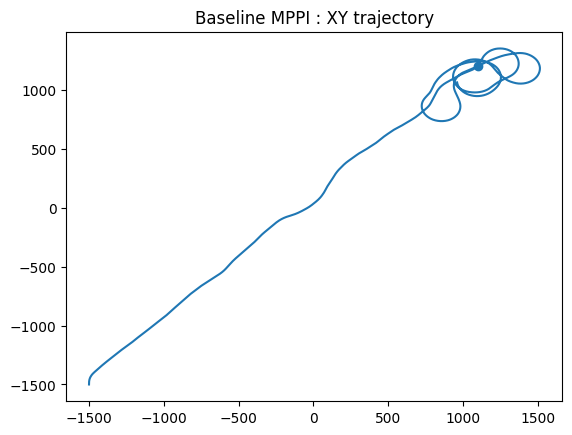

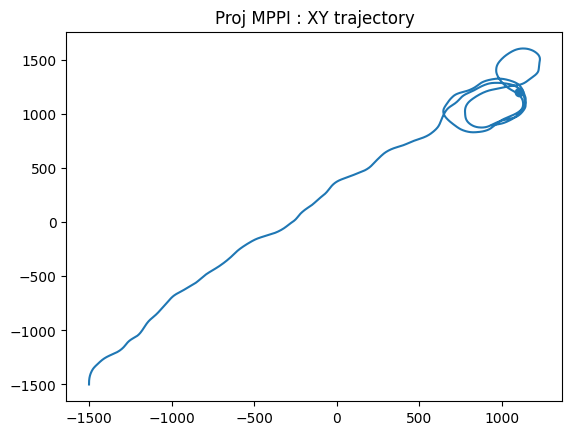

In [13]:
plt.figure()
plt.plot(states_base_global[case_num,:,0],states_base_global[case_num,:,1])
plt.scatter(goal_location[case_num,0],goal_location[case_num,1])
plt.title('Baseline MPPI : XY trajectory')
plt.show()

plt.figure()
plt.plot(states_proj_global[case_num,:,0],states_proj_global[case_num,:,1])
plt.scatter(goal_location[case_num,0],goal_location[case_num,1])
plt.title('Proj MPPI : XY trajectory')
plt.show()

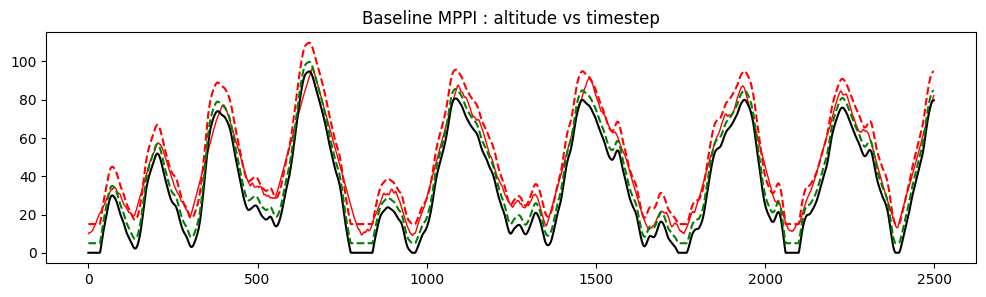

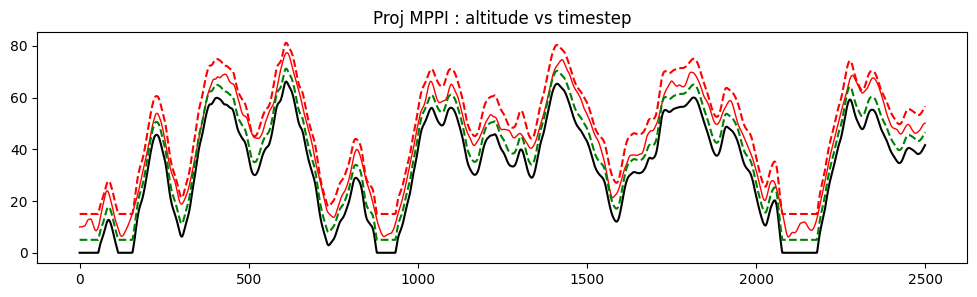

In [14]:
plt.figure(figsize=(12, 3))
plt.plot(states_base_global[case_num,:,2],linewidth=1,color = 'red')
plt.plot(z_terrain_base[case_num,:],color = 'black')
plt.plot(z_terrain_base[case_num,:] + terrain_lower,linestyle='--',color = 'green')
plt.plot(z_terrain_base[case_num,:] + terrain_upper,linestyle='--',color = 'red')
plt.title('Baseline MPPI : altitude vs timestep')
plt.show()


plt.figure(figsize=(12, 3))
plt.plot(states_proj_global[case_num,:,2],linewidth=1,color = 'red')
plt.plot(z_terrain_proj[case_num,:],color = 'black')
plt.plot(z_terrain_proj[case_num,:] + terrain_lower,linestyle='--',color = 'green')
plt.plot(z_terrain_proj[case_num,:] + terrain_upper,linestyle='--',color = 'red')
plt.title('Proj MPPI : altitude vs timestep')
plt.show()


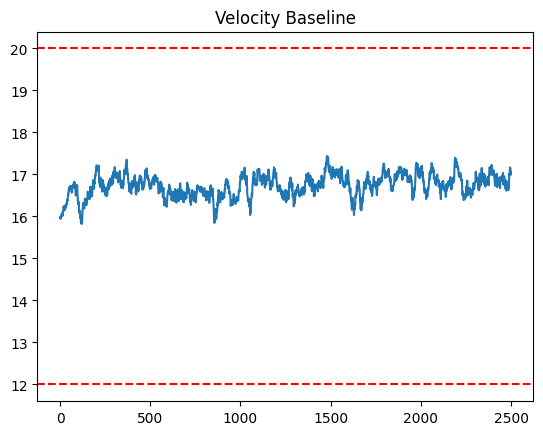

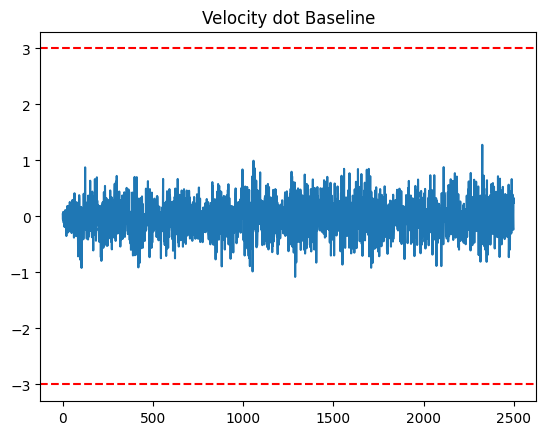

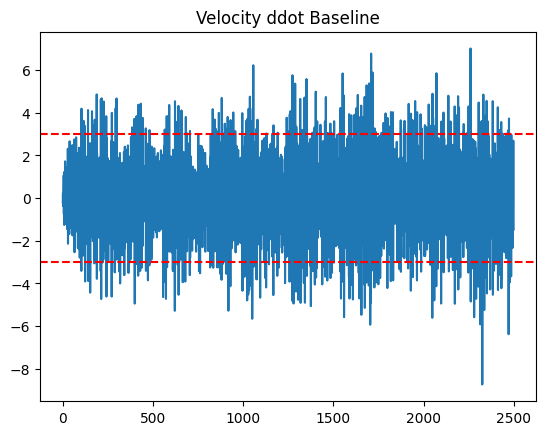

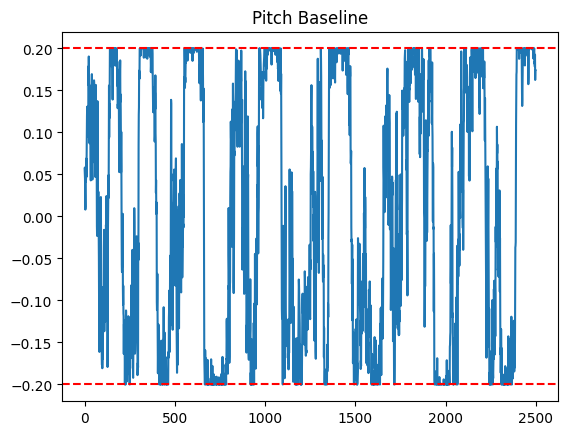

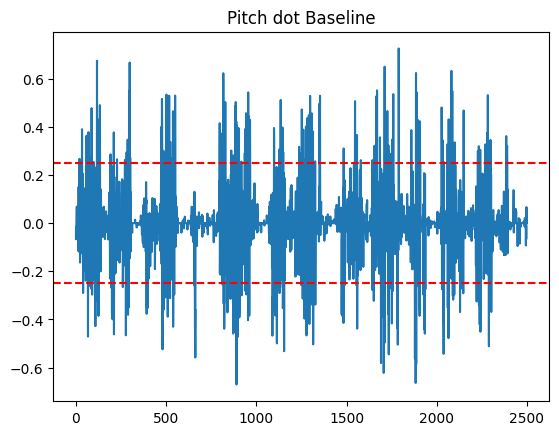

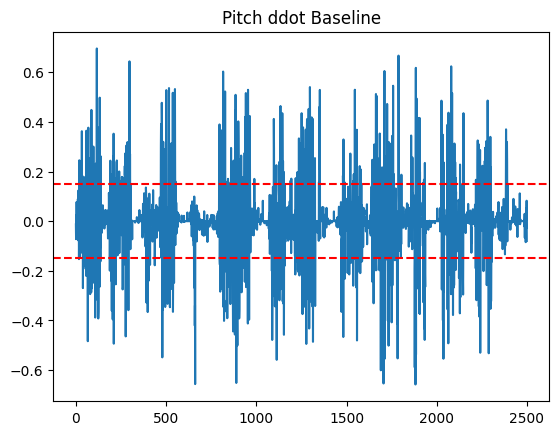

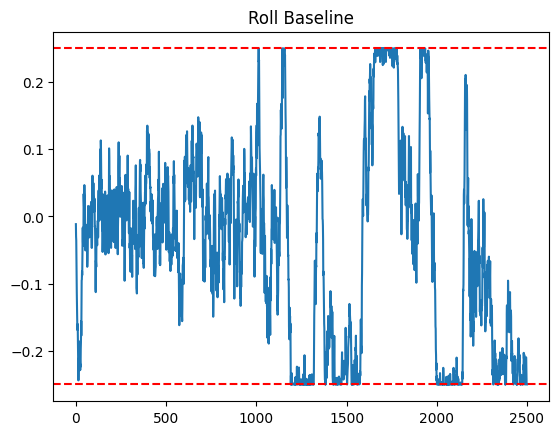

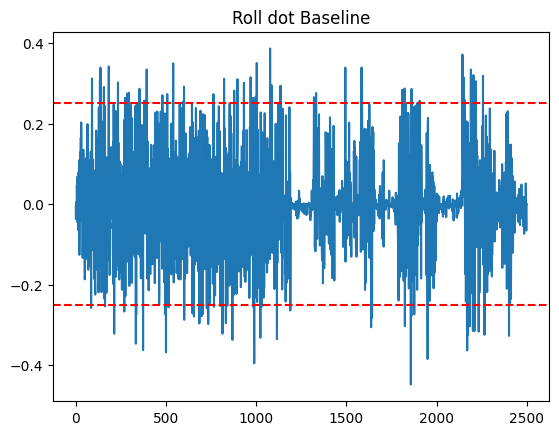

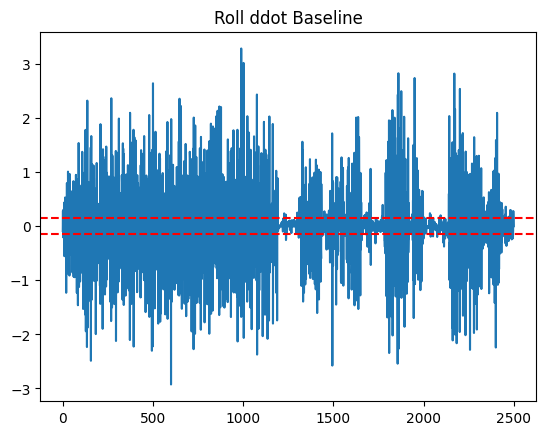

In [15]:
## Velocity/dot/ddot baseline ###
plt.figure()
plt.plot(controls_base[:,:,0].T)
plt.axhline(y=v_max, color='red', linestyle='--')
plt.axhline(y=v_min, color='red', linestyle='--')
plt.title('Velocity Baseline')
plt.show()

plt.figure()
plt.plot(dot_base[:,:,0].T)
plt.axhline(y=vdot_max, color='red', linestyle='--')
plt.axhline(y=vdot_min, color='red', linestyle='--')
plt.title('Velocity dot Baseline')
plt.show()

plt.figure()
plt.plot(ddot_base[:,:,0].T)
plt.axhline(y=vddot_max, color='red', linestyle='--')
plt.axhline(y=vddot_min, color='red', linestyle='--')
plt.title('Velocity ddot Baseline')
plt.show()
 # Pitch/dot/ddot baseline ###

plt.figure()
plt.plot(controls_base[:,:,1].T)
plt.axhline(y=pitch_max, color='red', linestyle='--')
plt.axhline(y=pitch_min, color='red', linestyle='--')
plt.title('Pitch Baseline')
plt.show()

plt.figure()
plt.plot(dot_base[:,:,1].T)
plt.axhline(y=pitchdot_max, color='red', linestyle='--')
plt.axhline(y=pitchdot_min, color='red', linestyle='--')
plt.title('Pitch dot Baseline')
plt.show()

plt.figure()
plt.plot(ddot_base[:,:,1].T)
plt.axhline(y=pitchddot_max, color='red', linestyle='--')
plt.axhline(y=pitchddot_min, color='red', linestyle='--')
plt.title('Pitch ddot Baseline')
plt.show()

## Roll/dot/ddot baseline ###

plt.figure()
plt.plot(controls_base[:,:,2].T)
plt.axhline(y=roll_max, color='red', linestyle='--')
plt.axhline(y=roll_min, color='red', linestyle='--')
plt.title('Roll Baseline')
plt.show()

plt.figure()
plt.plot(dot_base[:,:,2].T)
plt.axhline(y=rolldot_max, color='red', linestyle='--')
plt.axhline(y=rolldot_min, color='red', linestyle='--')
plt.title('Roll dot Baseline')
plt.show()

plt.figure()
plt.plot(ddot_base[:,:,2].T)
plt.axhline(y=rollddot_max, color='red', linestyle='--')
plt.axhline(y=rollddot_min, color='red', linestyle='--')
plt.title('Roll ddot Baseline')
plt.show()

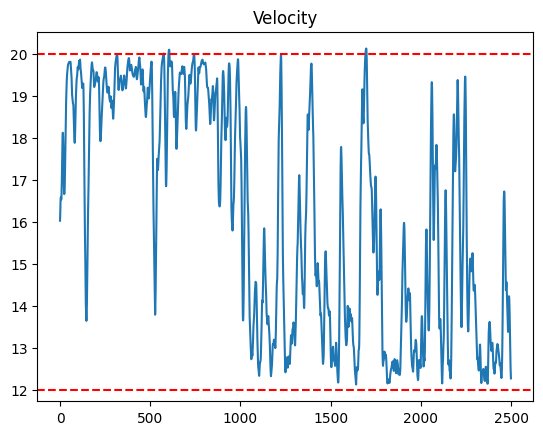

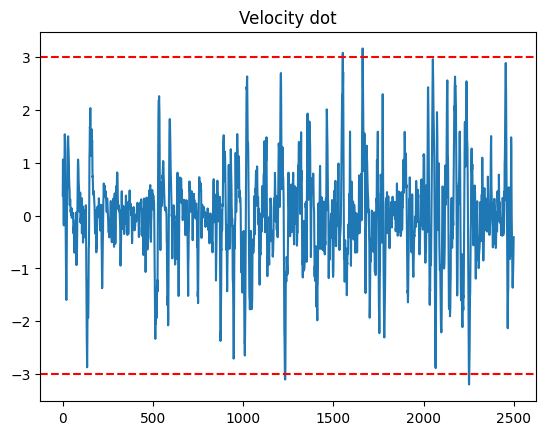

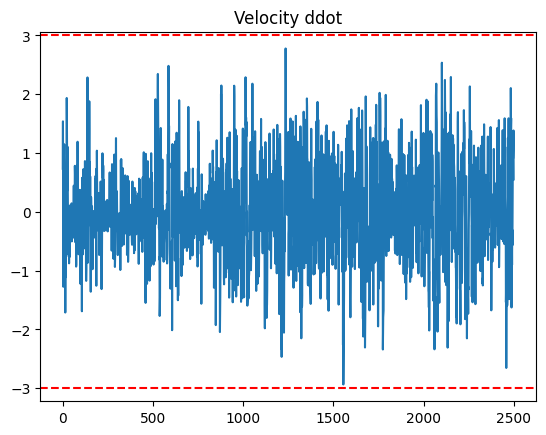

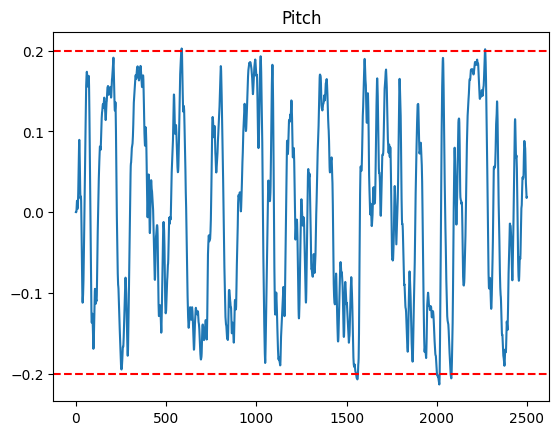

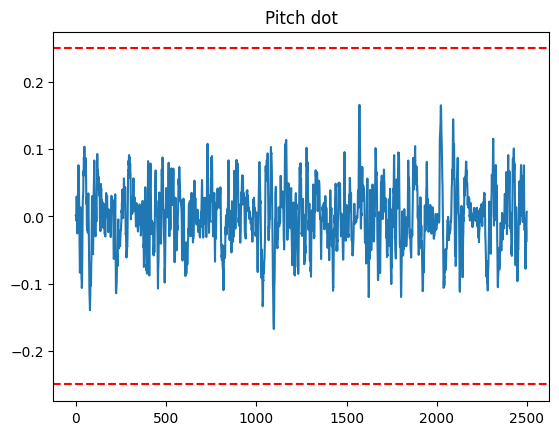

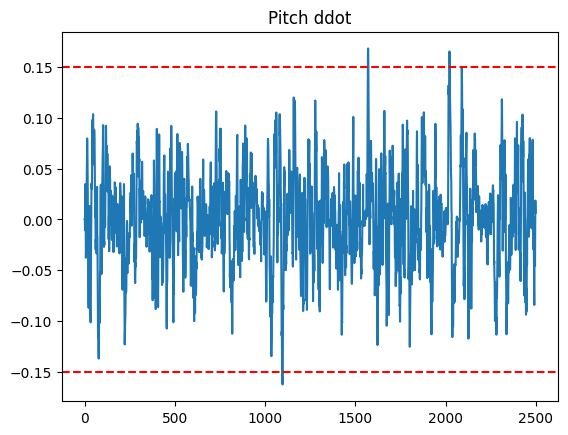

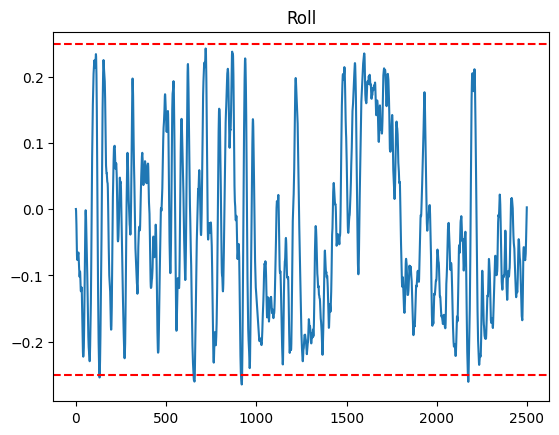

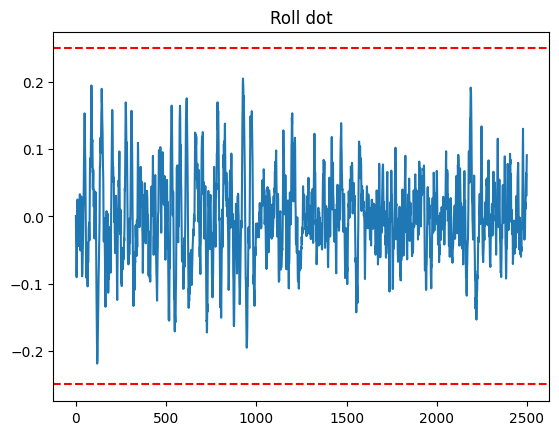

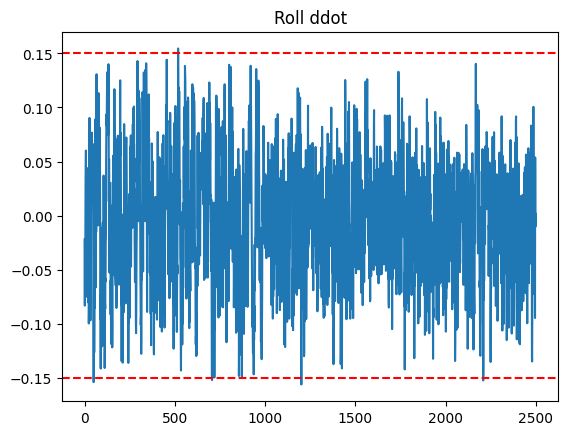

In [16]:
### Velocity/pitch/roll proj mppi ###

plt.figure()
plt.plot(controls_proj[:,:,0].T)
plt.axhline(y=v_max, color='red', linestyle='--')
plt.axhline(y=v_min, color='red', linestyle='--')
plt.title('Velocity')
plt.show()

plt.figure()
plt.plot(controls_dot_proj[:,:,0].T)
plt.axhline(y=vdot_max, color='red', linestyle='--')
plt.axhline(y=vdot_min, color='red', linestyle='--')
plt.title('Velocity dot')
plt.show()

plt.figure()
plt.plot(controls_ddot_proj[:,:,0].T)
plt.axhline(y=vddot_max, color='red', linestyle='--')
plt.axhline(y=vddot_min, color='red', linestyle='--')
plt.title('Velocity ddot')
plt.show()

plt.figure()
plt.plot(controls_proj[:,:,1].T)
plt.axhline(y=pitch_max, color='red', linestyle='--')
plt.axhline(y=pitch_min, color='red', linestyle='--')
plt.title('Pitch')
plt.show()

plt.figure()
plt.plot(controls_dot_proj[:,:,1].T)
plt.axhline(y=pitchdot_max, color='red', linestyle='--')
plt.axhline(y=pitchdot_min, color='red', linestyle='--')
plt.title('Pitch dot')
plt.show()

plt.figure()
plt.plot(controls_ddot_proj[:,:,1].T)
plt.axhline(y=pitchddot_max, color='red', linestyle='--')
plt.axhline(y=pitchddot_min, color='red', linestyle='--')
plt.title('Pitch ddot')
plt.show()  

plt.figure()
plt.plot(controls_proj[:,:,2].T)
plt.axhline(y=roll_max, color='red', linestyle='--')
plt.axhline(y=roll_min, color='red', linestyle='--')
plt.title('Roll')
plt.show()

plt.figure()
plt.plot(controls_dot_proj[:,:,2].T)
plt.axhline(y=rolldot_max, color='red', linestyle='--')
plt.axhline(y=rolldot_min, color='red', linestyle='--')
plt.title('Roll dot')
plt.show()

plt.figure()
plt.plot(controls_ddot_proj[:,:,2].T)
plt.axhline(y=rollddot_max, color='red', linestyle='--')
plt.axhline(y=rollddot_min, color='red', linestyle='--')
plt.title('Roll ddot')
plt.show()